In [27]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from spellchecker import SpellChecker
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
def clean_text(text):
        text = text.lower()

        text = re.sub(r'[^a-z\s]', '', text)

        spell = SpellChecker()
        corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in text.split()]

        text = ' '.join(corrected_words)

        return text

In [30]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))


N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))

# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

print("...")
rows = np.arange(N - 5, N)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)
row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very good and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We ordered the duck rare and it was pink and tender on the inside with a nice char on the outside.
row  2399 | y = 1 | Service was good and the company was better!


In [17]:
# Clean the text data
# x_train_df['cleaned_text'] = x_train_df['text'].apply(clean_text)
# train_sentences = x_train_df['cleaned_text'].tolist()
# y_train = y_train_df['is_positive_sentiment'].values

# just for a progress bar - same as above, but with progress bar
tqdm.pandas()

# Clean the text data with progress tracking
x_train_df['cleaned_text'] = x_train_df['text'].progress_apply(clean_text)
train_sentences = x_train_df['cleaned_text'].tolist()
y_train = y_train_df['is_positive_sentiment'].values

100%|██████████| 2400/2400 [04:39<00:00,  8.59it/s]


In [18]:
vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.7)

# Transform the training data into the BoW matrix
X_train_bow = vectorizer.fit_transform(train_sentences)

In [26]:
# Define the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear')

# Define the hyperparameter grid for regularization (C) and penalty types
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Different values of regularization strength
    'penalty': ['l1', 'l2']        # Different penalty types
}

# Use AUROC as the scoring metric
scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Initialize variables to store the best result across different fold searches
best_overall_model = None
best_overall_params = None
best_overall_score = -1
best_num_folds = None  # To keep track of the number of folds for the best parameters

# Loop through different values of CV (3, 4, 5 folds)
for num_folds in [3, 4, 5]:
    print(f"Performing GridSearch with {num_folds} CV folds...")
    
    # Define the KFold cross-validator for the current fold size
    kf = KFold(n_splits=num_folds)
    
    # Initialize the grid search for the current CV fold
    grid_search = GridSearchCV(log_reg, param_grid=param_grid, 
                               scoring=scorer, cv=kf, n_jobs=-1)
    
    # Perform the grid search on the training data
    grid_search.fit(X_train_bow, y_train)
    
    # Get the best model and score for the current fold
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best parameters for {num_folds} CV folds: {best_params}")
    print(f"Best AUROC for {num_folds} CV folds: {best_score}")
    
    # Compare with the overall best score
    if best_score > best_overall_score:
        best_overall_model = best_model
        best_overall_params = best_params
        best_overall_score = best_score
        best_num_folds = num_folds  # Update the number of folds for the best parameters

# Final best result after searching through all folds
print(f"\nBest parameters overall: {best_overall_params}")
print(f"Best AUROC overall: {best_overall_score}")
print(f"Number of folds for best parameters: {best_num_folds}")

Performing GridSearch with 3 CV folds...
Best parameters for 3 CV folds: {'C': 1, 'penalty': 'l2'}
Best AUROC for 3 CV folds: 0.7245833333333334
Performing GridSearch with 4 CV folds...
Best parameters for 4 CV folds: {'C': 1, 'penalty': 'l1'}
Best AUROC for 4 CV folds: 0.6346875
Performing GridSearch with 5 CV folds...
Best parameters for 5 CV folds: {'C': 1, 'penalty': 'l1'}
Best AUROC for 5 CV folds: 0.7055625

Best parameters overall: {'C': 1, 'penalty': 'l2'}
Best AUROC overall: 0.7245833333333334
Number of folds for best parameters: 3


/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


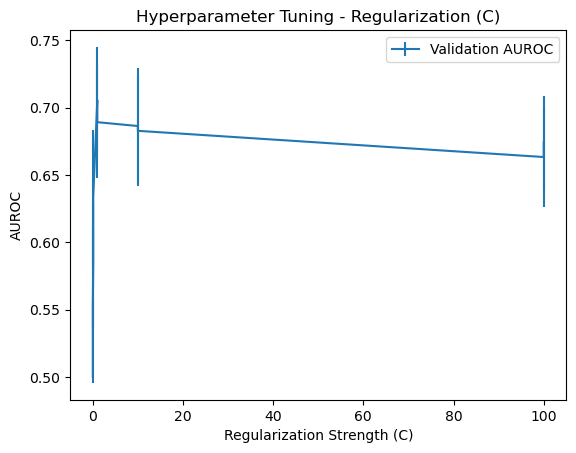

In [28]:
# Get the results from grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plot training and validation AUROC
plt.errorbar(results['param_C'], results['mean_test_score'], yerr=results['std_test_score'], label='Validation AUROC')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('AUROC')
plt.title('Hyperparameter Tuning - Regularization (C)')
plt.legend()
plt.show()

In [32]:
# Train the final model on the full training data using the best C
final_model = LogisticRegression(C=best_params['C'], solver='liblinear')
final_model.fit(X_train_bow, y_train)

# Apply on test data
x_test_df['cleaned_text'] = x_test_df['text'].apply(clean_text)

# Transform test data using the trained vectorizer
X_test_bow = vectorizer.transform(x_test_df['cleaned_text'].tolist())

# Predict probabilities
y_test_pred = final_model.predict_proba(X_test_bow)[:, 1]


In [33]:
np.savetxt('yproba1_test.txt', y_test_pred, delimiter='\n', fmt='%.6f')  # fmt='%.6f' for six decimal places
